# TP 1 : Compression d'images JPEG

Ce TP de multimédia est réalisé en Python3, à l'aide de la librairie scikit-image. Les tableaux utilisés par cette librairie pour manipuler les images (ndarray) proviennent de la librairie numpy. La documentation de ces deux librairies vous sera donc bien utile.

**Note:** Tous les scripts de ce TP travaillent par défaut sur une image d'exemple (un chat...), mais d'autres images sont également fournies avec le TP afin que vous puissiez évaluer les algorithmes dans diverses situations. Vous pouvez également utiliser vos propres images.

## Prélude : les principes de la compression JPEG

La figure ci-dessous représente les différentes étapes réalisées lors de la compression et la décompression d'images au format JPEG. Dans ce TP, on ne verra pas en détail l'ensemble de ces opérations, mais nous allons malgré tout nous attarder sur les concepts fondamentaux de JPEG (en particulier l'utilisation de la Discrete Cosinus Transform (DCT), la quantification, ainsi que le codage des coefficients obtenus).

![Mon image d'illustration](figure/jpeg-encoder.gif)

## Sous-échantillonnage

Une façon simple de réduire la quantité d'information que contient une image est de la sous-échantillonner (càd réduire sa taille). C'est ce que fait le script ci-dessous : on sous-échantillonne (compression), puis sur-échantillonne (décompression) une image avec différentes méthodes.


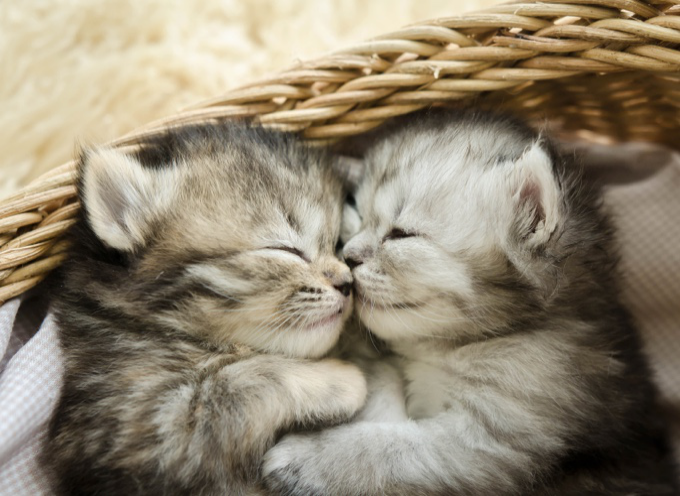


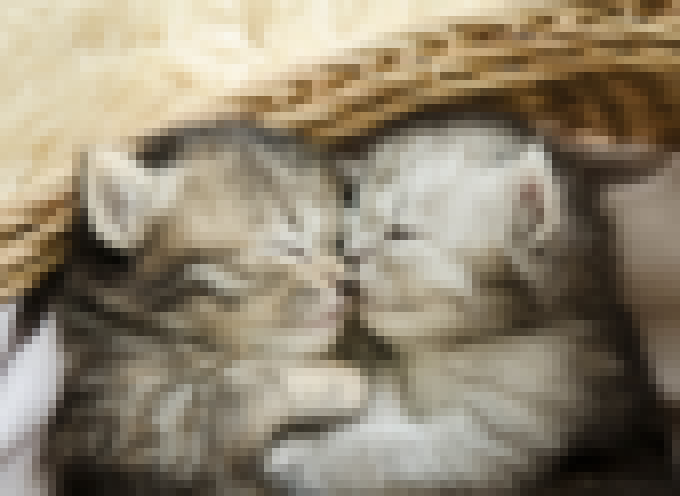


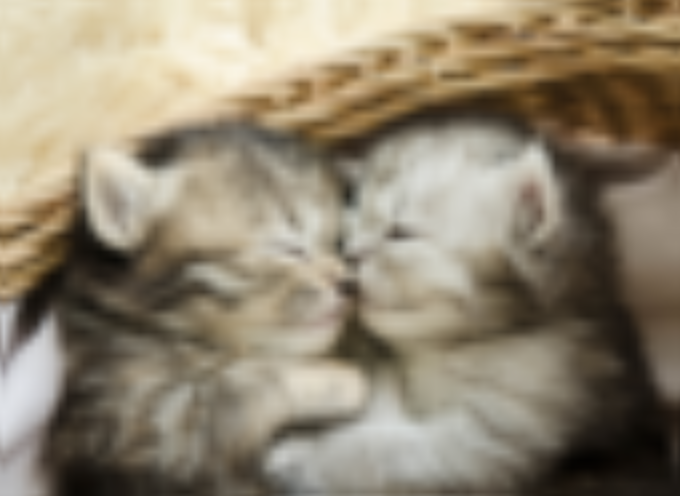


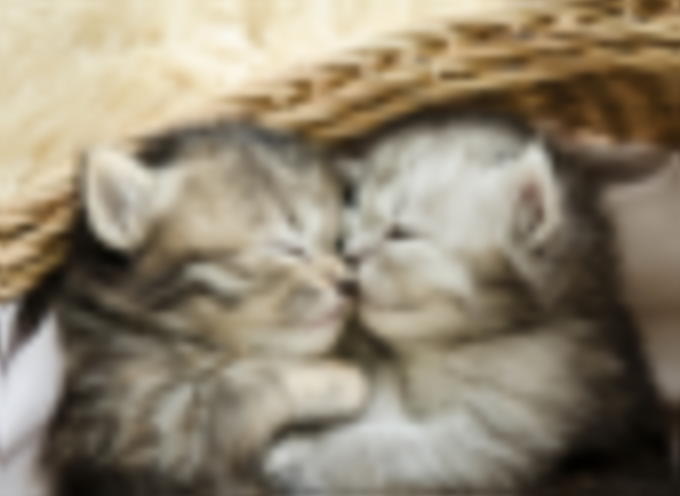

PSNR après sous + sur échantillonnage global (plus proche voisin):  23.40569987728631
PSNR après sous + sur échantillonnage global (bilinéaire):  23.88561120706595
PSNR après sous + sur échantillonnage global (bicubique):  24.5606664942177


In [2]:
# on importe tout ce qu'il faut pour la suite du TP
import numpy as np
import random
from skimage import io
from skimage import transform
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from skimage import color
from skimage import metrics
from scipy import fftpack

# pour que l'affichage des matrices soit facilement lisible (plus tard dans le TP)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=0)
np.set_printoptions(threshold=1000)

# une sous-figure
fig = make_subplots(rows=2, cols=2)

# on charge une image
image = io.imread('./chat.jpg')

# on la redimensionne à un multiple de 8 pixels (ca simplifiera notre travail plus tard)
image = transform.resize(image,(image.shape[0]//8*8,image.shape[1]//8*8))
fig = px.imshow(image)
fig.update_layout( title_text="Image originale", title_x=0.5)
fig.show()
width=image.shape[1]
height=image.shape[0]

# le facteur de sous-échantillonage utilisé
downscale = 8

# sous échantillonnage de l'image 
downsampled=transform.resize(image,(height//downscale,width//downscale))

# puis remise à l'échelle
subsampled0=transform.resize(downsampled,(height,width),order=0)
subsampled1=transform.resize(downsampled,(height,width),order=1)
subsampled2=transform.resize(downsampled,(height,width),order=3)

# Affichage des images et mesure de qualité
fig = px.imshow(subsampled0)
fig.update_layout( title_text="Plus proche voisin", title_x=0.5)
fig.show()
fig = px.imshow(subsampled1)
fig.update_layout( title_text="Bilinéaire", title_x=0.5)
fig.show()
fig = px.imshow(subsampled2)
fig.update_layout( title_text="Bicubique", title_x=0.5)
fig.show()
print("PSNR après sous + sur échantillonnage global (plus proche voisin): ", metrics.peak_signal_noise_ratio(image,subsampled0))
print("PSNR après sous + sur échantillonnage global (bilinéaire): ", metrics.peak_signal_noise_ratio(image,subsampled1))
print("PSNR après sous + sur échantillonnage global (bicubique): ", metrics.peak_signal_noise_ratio(image,subsampled2))

**Question 1:** Testez différents facteurs de sous-échantillonnage (ex: 2, 4, 8). 

1. Pour chacun, quel est le taux de compression et le PSNR obtenu ? 
2. La qualité obtenue est elle bonne (vous trouverez quelques rappels sur le PSNR ici https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) ?

**Réponse 1:**

Le sous-échantillonnage de toute l'image est peut être un peu excessif... Nous pouvons par contre tirer partie de certaines caractéristiques de notre système visuel pour réduire la quantité de données par sous-échantillonnage de manière moins visible. Pour cela on va utiliser un espace de couleur différent du classique RGB. On utilisera ici l'espace LUV (JPEG utilise l'espace YCrCb / YUV, assez proche mais non géré par scikit-image).


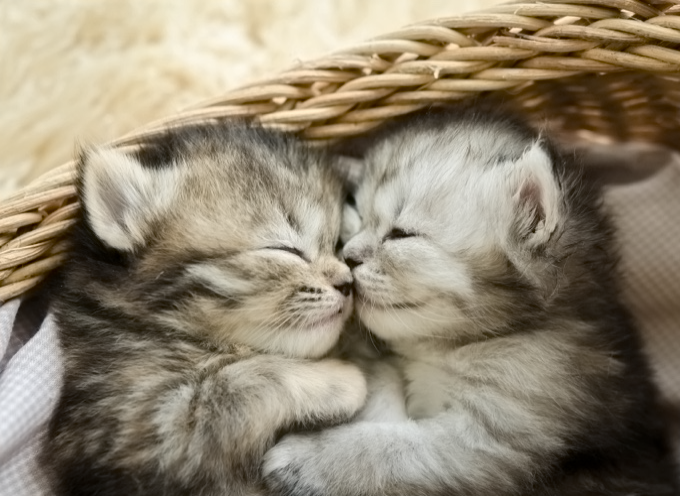

PSNR après sous + sur échantillonnage de la chrominance:  38.823908561636465


In [5]:
# le facteur de sous-échantillonage utilisé
downscale = 8

# on passe dans un espace couleur plus adapté
# et on fait un sous-échantillonnage de la seule chrominance
imageYUV = color.rgb2luv(image)

L=imageYUV[:,:,0]
U=imageYUV[:,:,1]
V=imageYUV[:,:,2]

# sous échantillonnage des canaux U et V
U=transform.resize(U,(height//downscale,width//downscale))
V=transform.resize(V,(height//downscale,width//downscale))
# puis remise à l'échelle
U=transform.resize(U,(height,width))
V=transform.resize(V,(height,width))
# On reconstitue ensuite l'image d'origine avec le canal qui a été sous-échantillonné
subsampled=imageYUV.copy()
subsampled[:,:,1] = U
subsampled[:,:,2] = V
subsampled = color.luv2rgb(subsampled)
fig = px.imshow(subsampled)
fig.update_layout( title_text="Sous échantillonnage de la chrominance", title_x=0.5)
fig.show()

print("PSNR après sous + sur échantillonnage de la chrominance: ", metrics.peak_signal_noise_ratio(image,subsampled))

**Question 2:** 

1. Tout comme dans la question 1, faire varier le facteur de sous-échantillonnage et observer la qualité d'image obtenue (visuellement et via le PSNR). Indiquez également le facteur de compression obtenu. 
2. Expliquez les résultats obtenus (en particulier, ce qui change entre RGB et YUV et quelle influence cela a sur la qualité des images). Pensez à tester l'image clown.jpg, plus colorée que les chats...

**Réponse 2:** 

## DCT

On a vu en traitement du signal et d'image qu'il était possible de représenter une image non pas par des informations spatiales, mais par des informations fréquentielles. La tranformée de fourrier discrète (DFT ou FFT) permet de réaliser cette transformation, mais ce n'est pas la seule. La transformée en cosinus discrète (DCT) en est une autre qui a des propriétés intéressantes.

Note: pour simplifier les choses on travaillera sur des images en niveau de gris, mais les principes vus dans cette section peuvent être étendus simplement en travaillant sur chacun des 3 canaux couleur de l'image (Y, Cb et Cr dans le cas de JPEG).

In [7]:
from scipy import fftpack

# affichons la base de fonctions de la DCT sur des blocs 8x8
fig = make_subplots(rows=8, cols=8)
for i in range (0,8):
    for j in range(0,8):
        a=np.zeros((8,8))
        a[i,j]=1
        # on fait une DCT 2D avec 2 DCT 1D
        ia=fftpack.idct(fftpack.idct(a).T).T
        #ax[i,j].imshow(ia,cmap='gray')
        fig.add_trace(px.imshow(ia, binary_string=True).data[0], row=1+i, col=1+j)
fig.update_xaxes(visible=False) 
fig.update_yaxes(visible=False) 
fig.show()

**Question 3:** 
1. Examiner et expliquer la base de fonctions de la DCT générée par le script ci-dessus.
2. Parmi la DCT sur des blocs 8x8 faite en JPEG et la transformée de Fourier discrète que l'on appliquerait globalement sur l'image, quelle(s) transformée(s) :
    - Permet(tent) d'analyser la répartition de l'énergie selon les fréquences ?
    - Fournit une information sur la localisation dans l'image de ces fréquences ?
3. Quel autre outil permet de mieux traiter ce problème de localisation et analyse en fréquence simultanées ? Est-il utilisé dans certains formats de compression d'image ?

**Réponse 3:**

Le script suivant calcul les coefficients DCT de tous les blocs 8x8 qui composent notre image.


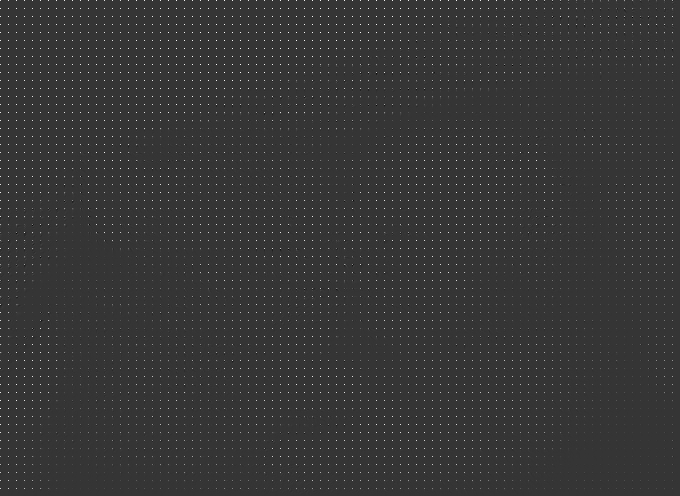

exemple de coefficients DCT d'un bloc 8x8
[[ 685.  -23.  -28.  -11.   -0.  -13.   15.    7.]
 [-215.   59.  -19.  -22.   -7.   -0.  -23.   -7.]
 [  25.   -1.   12.   11.   12.   -6.  -17.   -7.]
 [  -8.  -17.   18.   -7.   15.   26.    5.   -2.]
 [   0.    6.   -7.    7.  -19.   -4.   -0.   -5.]
 [  -5.   -2.   -5.   12.    4.    1.   -2.    4.]
 [   9.   -5.    1.   -8.    2.   -2.    1.   -0.]
 [  -2.    3.   -4.    5.    1.    1.    1.    0.]]


In [8]:
# calcul des coefficients DCT de chaque bloc 8x8
greyimg=color.rgb2gray(image)
dctimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=greyimg[y:y+8,x:x+8]
        dctimg[y:y+8,x:x+8]=fftpack.dct(fftpack.dct(bloc,norm='ortho').T,norm='ortho').T

fig = px.imshow(dctimg, binary_string=True)
fig.update_layout( title_text="Coefficients DCT de l'image", title_x=0.5)
fig.show()

# on affiche également les valeurs d'un bloc 8x8
print("exemple de coefficients DCT d'un bloc 8x8")
x=20*8
y=20*8
print((255*dctimg[y:y+8,x:x+8]).round())

**Question 4:** 
1. Quelle est la taille de l'image obtenue ? Quelle aurait été la taille de l'image si on avait utilisé une FFT ?
2. Faites le lien entre la base de fonctions de la DCT et les coefficients obtenus pour chaque bloc 8x8.
3. Quelle est en particulier la signification du coefficient situé dans le coin haut-gauche de chaque bloc (ne pas se fier à la valeur affichée, celle-ci dépend de la normalisation utilisée pour la DCT) ?

**Réponse 4:**

On effectue maintenant la transformation inverse pour regénérer l'image d'origine (on ne compresse donc pour l'instant pas)


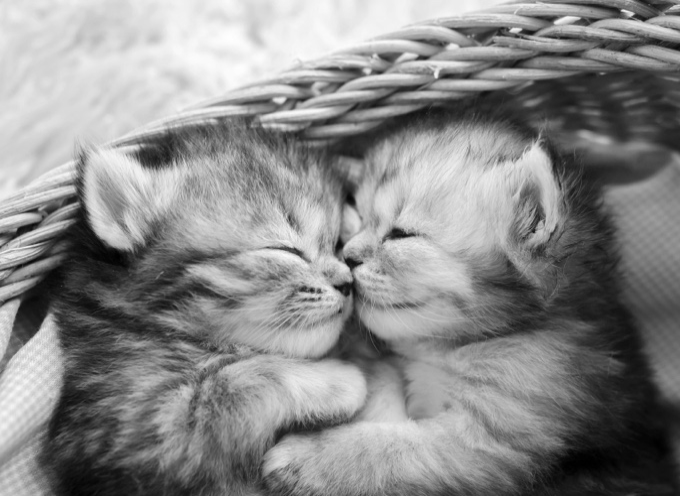

PSNR après DCT / iDCT:  313.7492339396977
% de coefficients nuls 0.0


In [9]:
# reconstruction "parfaite"
compressedimg=np.zeros(greyimg.shape)

for y in range(0,height,8):
    for x in range(0, width,8):
        bloc=dctimg[y:y+8,x:x+8]
        compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(bloc,norm='ortho').T,norm='ortho').T

fig = px.imshow(compressedimg, binary_string=True)
fig.update_layout( title_text="Reconstruction 'parfaite", title_x=0.5)
fig.show()

print("PSNR après DCT / iDCT: ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))
print("% de coefficients nuls", 100*(dctimg == 0).sum()/greyimg.size)


**Question 5:** Le PSNR obtenu correspond-il à celui que vous attendiez (théoriquement) ? Pourquoi ?

**Réponse 5**:

Il est temps de compresser notre image... Pour cela nous allons effectuer une quantification des coefficients DCT afin de limiter l'ensemble des valeures possibles et ainsi faciliter la compression (sans perte cette fois ci) de ces coefficients simplifiés.

Exemple de coefficients DCT d'un bloc 8x8 après quantification n*Q avec n= 4
[[ 704.  -44.  -40.   -0.   -0.   -0.    0.    0.]
 [-192.   48.   -0.   -0.   -0.   -0.   -0.   -0.]
 [   0.   -0.    0.    0.    0.   -0.   -0.   -0.]
 [  -0.   -0.    0.   -0.    0.    0.    0.   -0.]
 [   0.    0.   -0.    0.   -0.   -0.   -0.   -0.]
 [  -0.   -0.   -0.    0.    0.    0.   -0.    0.]
 [   0.   -0.    0.   -0.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR après DCT / quantification / iDCT:  31.50017626090476
% de coefficients nuls 94.94574240986718



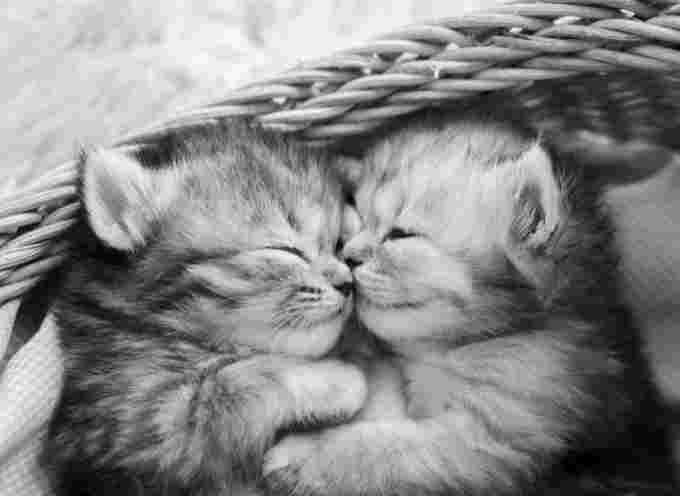

Exemple de coefficients DCT d'un bloc 8x8 après quantification n*Q avec n= 1
[[ 688.  -22.  -30.  -16.   -0.   -0.    0.    0.]
 [-216.   60.  -14.  -19.   -0.   -0.   -0.   -0.]
 [  28.   -0.   16.    0.    0.   -0.   -0.   -0.]
 [ -14.  -17.   22.   -0.    0.    0.    0.   -0.]
 [   0.    0.   -0.    0.   -0.   -0.   -0.   -0.]
 [  -0.   -0.   -0.    0.    0.    0.   -0.    0.]
 [   0.   -0.    0.   -0.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR après DCT / quantification / iDCT:  36.76837164235168
% de coefficients nuls 87.03717979127134



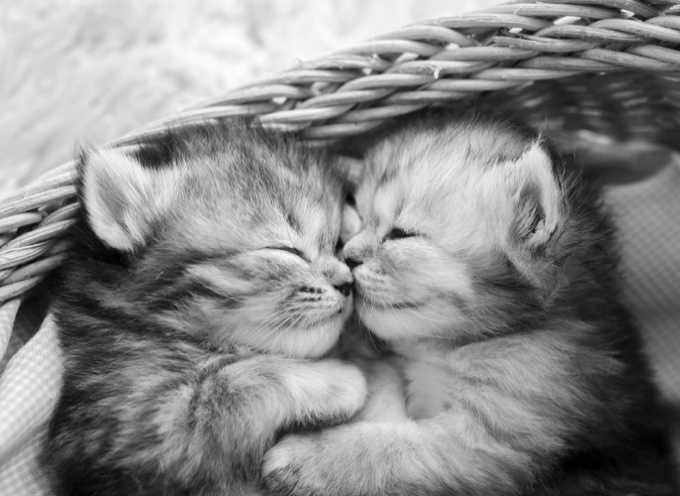

Exemple de coefficients DCT d'un bloc 8x8 après quantification n*Q avec n= 0.5
[[ 688.  -22.  -30.   -8.   -0.  -20.   26.    0.]
 [-216.   60.  -21.  -19.  -13.   -0.  -30.   -0.]
 [  28.   -0.    8.   12.   20.   -0.   -0.   -0.]
 [  -7.  -17.   22.   -0.   26.   44.    0.   -0.]
 [   0.   11.   -0.    0.  -34.   -0.   -0.   -0.]
 [  -0.   -0.   -0.    0.    0.    0.   -0.    0.]
 [   0.   -0.    0.   -0.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR après DCT / quantification / iDCT:  39.238708339695634
% de coefficients nuls 81.08870967741936



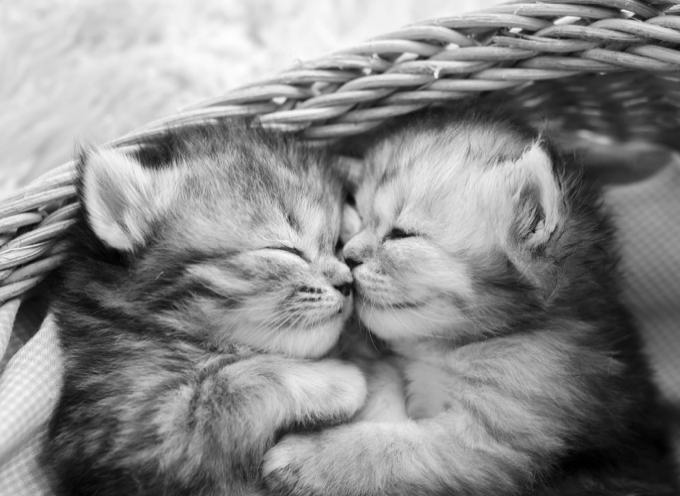

Exemple de coefficients DCT d'un bloc 8x8 après quantification n*Q avec n= 0.1
[[ 685.  -23.  -28.  -11.   -0.  -12.   15.    6.]
 [-215.   59.  -20.  -21.   -8.   -0.  -24.   -6.]
 [  25.   -1.   11.   10.   12.   -6.  -14.   -6.]
 [  -8.  -17.   18.   -6.   15.   26.    8.   -0.]
 [   0.    7.   -7.    6.  -20.   -0.   -0.   -8.]
 [  -5.   -0.   -6.   13.    8.    0.   -0.    0.]
 [  10.   -6.    0.   -9.    0.   -0.    0.   -0.]
 [  -0.    0.   -0.    0.    0.    0.    0.    0.]]
PSNR après DCT / quantification / iDCT:  46.88738079719065
% de coefficients nuls 61.09879032258065



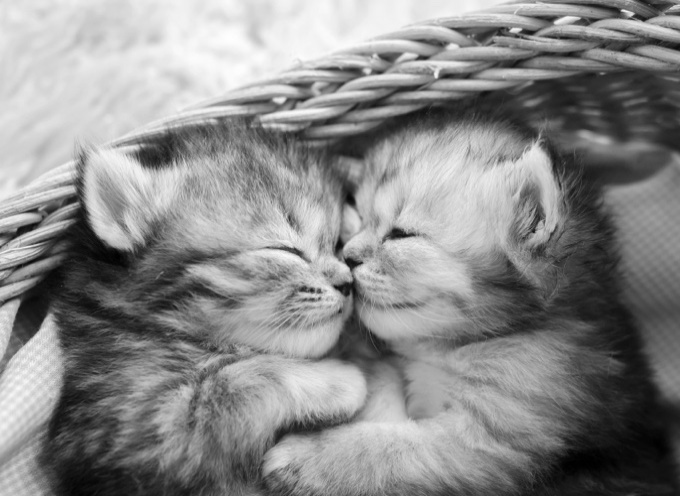

In [10]:
quantized=np.zeros(greyimg.shape)

# matrice de quantification standard de JPEG
Q=np.array([[16,11,10,16,24,40,51,61],
            [12,12,14,19,26,48,60,55],
            [14,13,16,24,40,57,69,56],
            [14,17,22,29,51,87,80,62],
            [18,22,37,56,68,109,103,77],
            [24,35,55,64,81,104,113,92],
            [49,64,78,87,103,121,120,101],
            [72,92,95,98,112,100,103,99]])/255

# On génère différentes qualités d'image (et donc taux de compression) en multipliant la matrice Q par un facteur variable
N=(4, 1, 0.5, 0.1)

for n in N:
    # quantification et reconstruction de l'image
    for y in range(0,height,8):
        for x in range(0, width,8):
            bloc=dctimg[y:y+8,x:x+8]
            quantized[y:y+8,x:x+8]=np.multiply(np.round(np.divide(bloc,n*Q)),n*Q)
            compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(quantized[y:y+8,x:x+8],norm='ortho').T,norm='ortho').T

    # si certaines valeurs dépassent les valeurs admissibles (>=0 et <1) on les tronque
    compressedimg[compressedimg>1]=1
    compressedimg[compressedimg<0]=0
    
    # on affiche les valeurs d'un bloc 8x8 après quantification
    print("Exemple de coefficients DCT d'un bloc 8x8 après quantification n*Q avec n=",n)
    x=20*8
    y=20*8
    print((255*quantized[y:y+8,x:x+8]).round())
    print("PSNR après DCT / quantification / iDCT: ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))
    print("% de coefficients nuls", 100*(quantized == 0).sum()/greyimg.size)
    
    fig = px.imshow(compressedimg, binary_string=True)
    fig.update_layout( title_text="Reconstruction après quantification n*Q avec n="+str(n), title_x=0.5)
    fig.show()
 


**Question 6:** 
1. Commenter la matrice de quantication (contenue dans la variable Q).
2. Observer le pourcentage de coefficients DCT nuls (en fonction de l'importance de la quantification). En quoi est-ce intéressant ?
3. Dans JPEG, les coefficients DCT sont réordonnés avec un codage zigzag avant d'être compressés (sans perte = RLE + Huffman). Pourquoi ?
![Mon image d'illustration](figure/zigzag.jpg)
4. Le PSNR s'affiche pour chaque cas. Tenter d'établir une correspondance entre qualité visuelle et PSNR.
5. Faire ce travail sur plusieurs images, en particulier commenter le résultat obtenu sur l'image maths.gif

**Réponse 6:**

## Transmission progressive

Le script ci-dessous montre un exemple (simplifié) de comment on pourrait transmettre les coefficients DCT de manière progressive (dans un contexte de transmission sur un réseau lent).


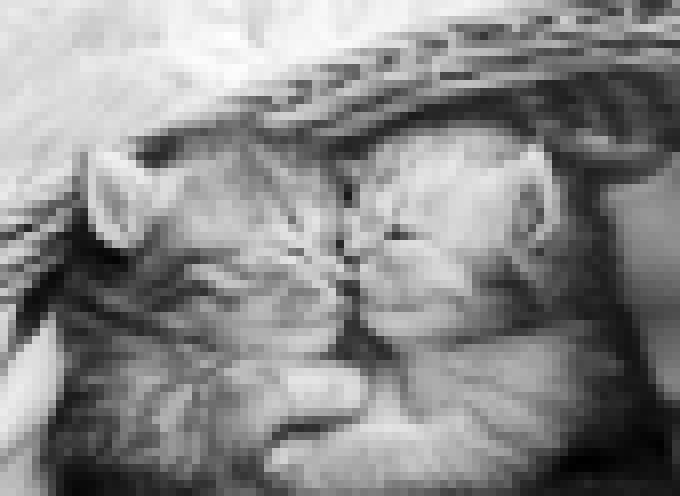

PSNR après transmission du niveau  0 :  23.66421220562806
% de coefficients nuls 98.4375



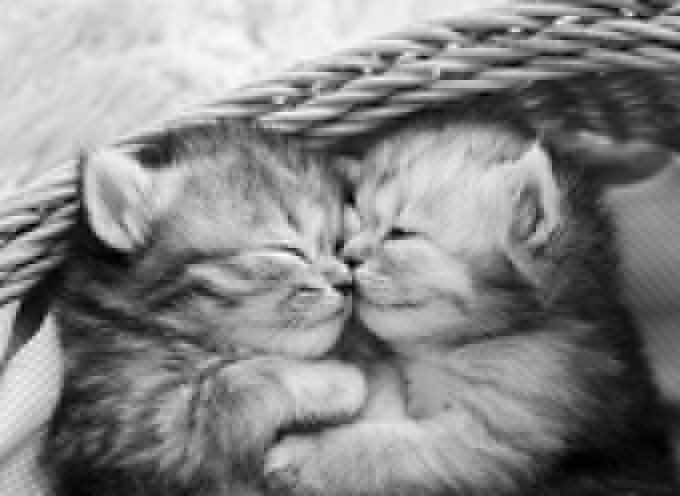

PSNR après transmission du niveau  1 :  29.226273712880797
% de coefficients nuls 93.84309772296015



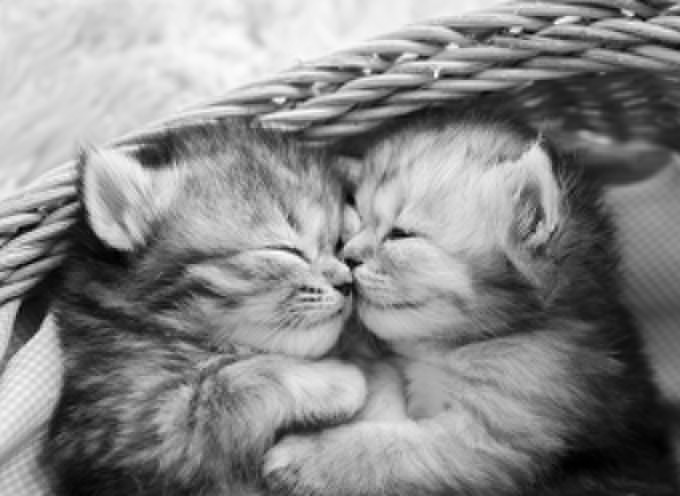

PSNR après transmission du niveau  2 :  33.17835505814715
% de coefficients nuls 86.68672912713473



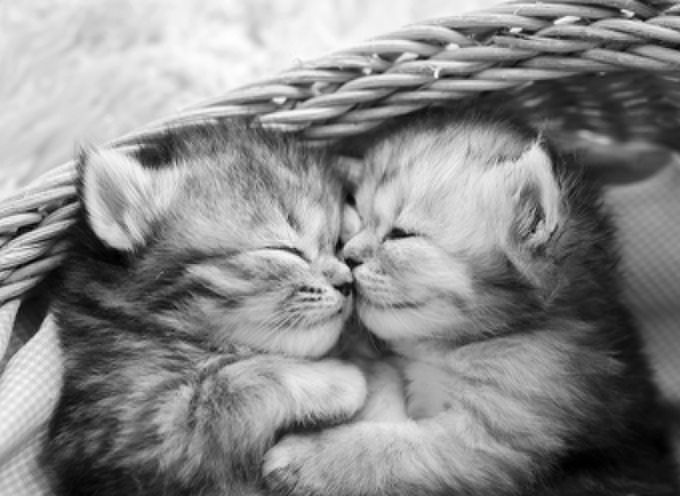

PSNR après transmission du niveau  3 :  36.289288410252425
% de coefficients nuls 78.31653225806451



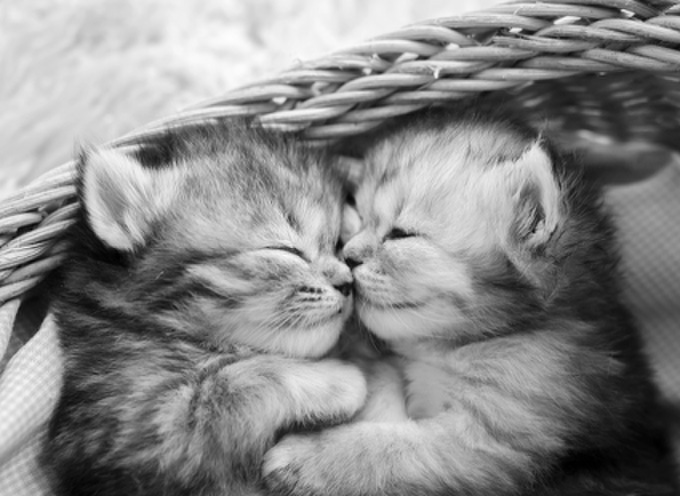

PSNR après transmission du niveau  4 :  39.37287161728171
% de coefficients nuls 70.74329933586338



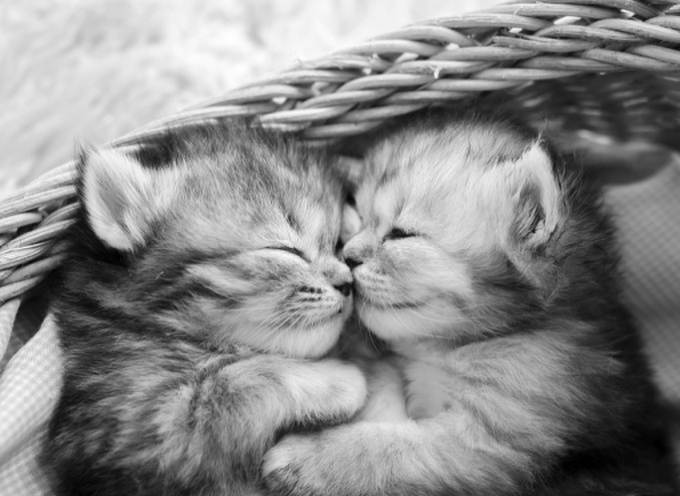

PSNR après transmission du niveau  5 :  42.25563000562255
% de coefficients nuls 65.56748102466793



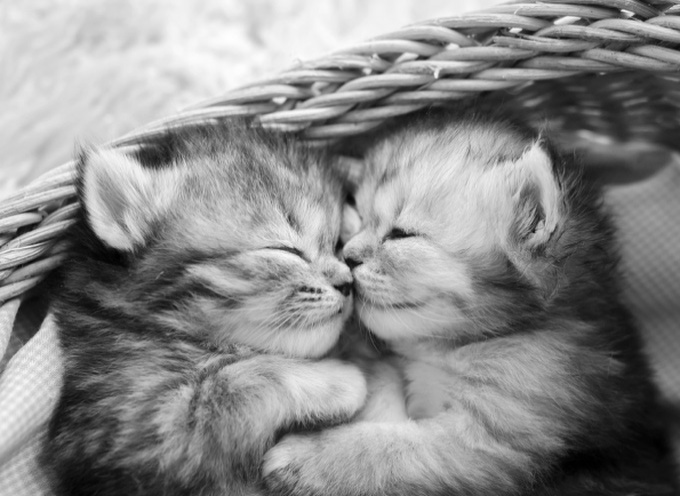

PSNR après transmission du niveau  6 :  44.7577383229434
% de coefficients nuls 62.76921252371916



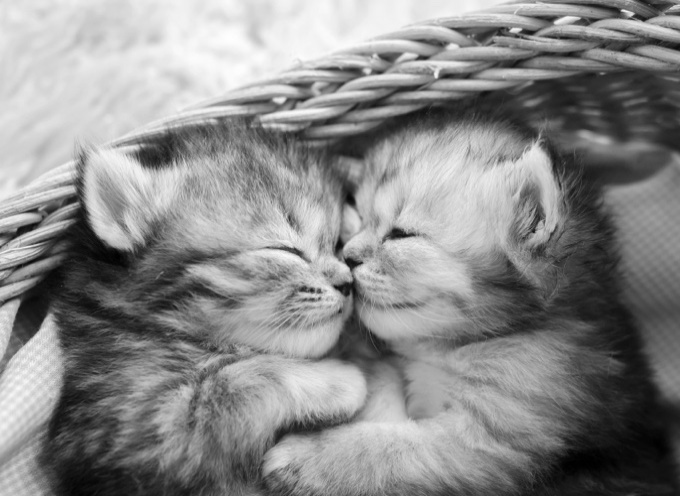

PSNR après transmission du niveau  7 :  46.88738079719065
% de coefficients nuls 61.09879032258065


In [11]:
# JPEG "progressif"
for level in range(0,8):
    for y in range(0,height*8//8,8):
        for x in range(0, width*8//8,8):
            bloc=np.zeros((8,8))
            bloc[0:level+1,0:level+1]=dctimg[y:y+level+1,x:x+level+1]
            quantized[y:y+8,x:x+8]=np.multiply(np.round(np.divide(bloc,Q*0.1)),Q*0.1)
            compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(quantized[y:y+8,x:x+8],norm='ortho').T,norm='ortho').T
    
    # si certaines valeurs dépassent les valeurs admissibles (>=0 et <1) on les tronque
    compressedimg[compressedimg>1]=1
    compressedimg[compressedimg<0]=0
    
    fig = px.imshow(compressedimg, binary_string=True)
    fig.update_layout( title_text="Reconstruction après transmission de "+ str(100*(level+1)*(level+1)/64) + "% des coefficients", title_x=0.5)
    fig.show()
    
    print("PSNR après transmission du niveau ", level,  ": ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))
    print("% de coefficients nuls", 100*(quantized == 0).sum()/greyimg.size)

**Question 7:** 
1. Quel est le principe de cette transmission progressive ?
2. Testez sur différents types d'image (et en particulier maths.gif). Cette méthode est-elle adapté pour tout type de contenu ?

**Réponse 7:**

## Encodage des coefficients DCT de fréquence nulle

Dans JPEG, les coefficients DCT de fréquence nulle (composante continue) subissent un codage DPCM. Le script ci-dessous devrait vous aider à comprendre pourquoi.


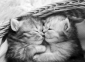

valeur moyenne, ecart-type de la composante continue de chaque bloc:  4.229738371035666 1.977170416873402



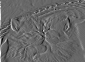

valeur moyenne, ecart-type  de la composante continue de chaque bloc après codage DPCM:  -0.0011678966267101507 0.7491941635904122


In [12]:
# Extraction de la composante continue / fréquence nulle des coefficients DCT
coefscont=np.zeros((height//8, width//8))
for y in range(0,height*8//8,8):
    for x in range(0, width*8//8,8):
        coefscont[y//8,x//8] = dctimg[y,x]
        
fig = px.imshow(coefscont, binary_string=True)
fig.update_layout( title_text="Coefficients de fréquence nulle", title_x=0.5)
fig.show()
print("valeur moyenne, ecart-type de la composante continue de chaque bloc: ", coefscont.mean(), coefscont.std())

# calcul de la différence entre une valeur DCT et la suivante
reshapeddc=coefscont.reshape((width*height//64,1))
dpcmcoefs=np.zeros(width*height//64)
for i in range(1,width*height//64):
    dpcmcoefs[i]=reshapeddc[i]-reshapeddc[i-1]
coefscont=dpcmcoefs.reshape((height//8,width//8))

fig = px.imshow(coefscont, binary_string=True)
fig.update_layout( title_text="Différence avec le coefficient précédent (gauche)", title_x=0.5)
fig.show()
print("valeur moyenne, ecart-type  de la composante continue de chaque bloc après codage DPCM: ", dpcmcoefs.mean(), dpcmcoefs.std())


**Question 8:**  Observez les résultat du script afin de:
1. Expliquer ce qu'est le codage DPCM
2. Justifier l'intéret de ce codage pour les coefficients de fréquence nulle.

**Réponse 8:**

## Correction des erreurs de transmission

Un bon décodeur doit être un bon (et rapide) maquilleur d'erreur : le script ci-dessous met a zéro quelques blocs de coefficients DCT dans l'image, simulant très grossièrement des problèmes de transmission.


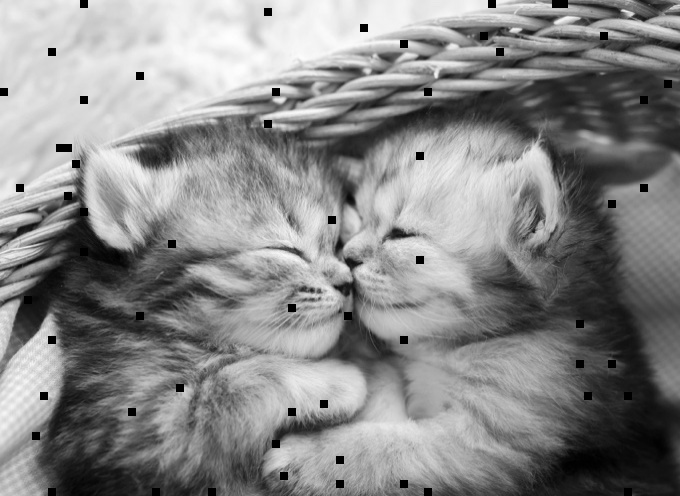

PSNR après erreurs:  23.960755735745902


In [13]:
# Simulation de perte de blocs lors de la transmission
dcterror=quantized.copy()
probaerror=0.01
for y in range(0,height,8):
    for x in range(0, width,8):
        if random.random() <= probaerror:
            dcterror[y:y+8,x:x+8] = 0;

# On insère ici le code du correcteur d'erreurs   
# C'est à vous de jouer !

# Décodage de l'image
for y in range(0,height,8):
    for x in range(0, width,8):
        compressedimg[y:y+8,x:x+8]=fftpack.idct(fftpack.idct(dcterror[y:y+8,x:x+8],norm='ortho').T,norm='ortho').T

fig = px.imshow(compressedimg, binary_string=True)
fig.update_layout( title_text="Image avec blocs manquants", title_x=0.5)
fig.show()
print("PSNR après erreurs: ", metrics.peak_signal_noise_ratio(greyimg,compressedimg))

**Question 9:** 
1. Quelle technique pourrait on utiliser pour masquer (partiellement) ces erreurs avant de décoder l'image ?
2. Mettez en oeuvre votre technique dans le script ci-dessus et constatez (normalement) l'amélioration du PSNR

**Réponse 9:**

## Amélioration du décodage

Vous avez pu constater que lorsque le taux de compression d'une image JPEG est important on voit clairement apparaitre la transition entre les différents blocs 8x8 de l'image.

**Question 10:** 
1. Comment pourrait-on améliorer l'image lors du décodage pour atténuer ces transitions ?
2. La manière dont ce filtrage est réalisé doit-elle figurer dans la norme JPEG ?

**Réponse 10:**

## Bonus : dithering

On a vu dans ce TP que la quantification des coefficients DCT était bien plus efficace que la quantification des valeurs des pixels (comme faite en TP d'image) pour réaliser une compression importante mais préservant la qualité de l'image.
Il y a cependant un moyen d'améliorer la qualité de la quantification directe de la valeur des pixels : le dithering...


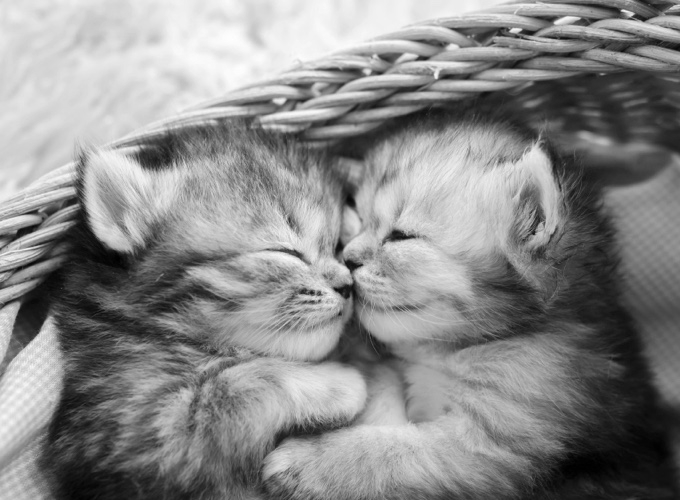


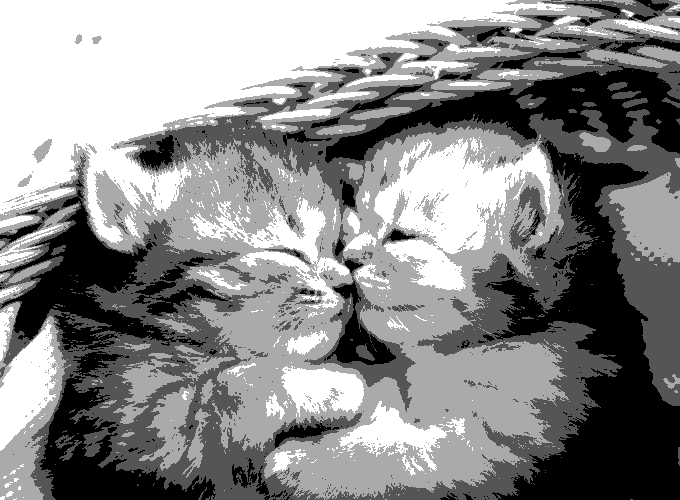


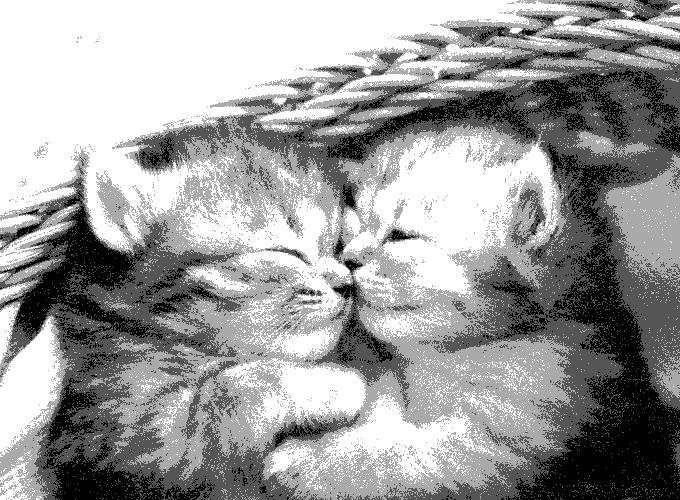


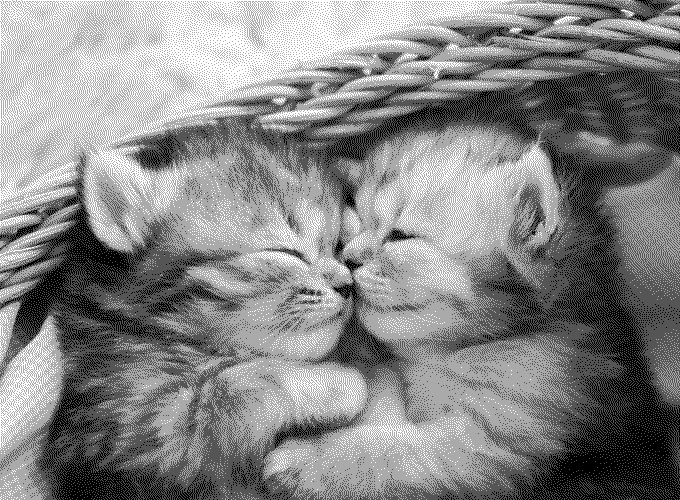

0.9820517647058823 1.0
PSNR quantification:  17.843651399156645
PSNR dithering: Image + Bruit:  16.0747649664102
PSNR Floyd-Steinberg:  17.267354070983686


In [14]:
from skimage.filters import threshold_otsu

def quantize(image, L=1, N=4):
    T = np.linspace(0, L, N, endpoint=False)[1:]
    return np.digitize(image.flat, T).reshape(image.shape)/(N-1)


def dither(image, N=4, positions=None, weights=None):
    """Quantize an image, using dithering.
    Parameters
    ----------
    image : ndarray
        Input image.
    N : int
        Number of quantization levels.
    positions : list of (i, j) offsets
        Position offset to which the quantization error is distributed.
        By default, implement Sierra's "Filter Lite".
    weights : list of ints
        Weights for propagated error.
        By default, implement Sierra's "Filter Lite".
    References
    ----------
    http://www.efg2.com/Lab/Library/ImageProcessing/DHALF.TXT
    """
    image = image.copy()

    if positions is None or weights is None:
        positions = [(0, 1), (1, -1), (1, 0)]
        weights = [2, 1, 1]

    weights = weights / np.sum(weights)

    T = np.linspace(0, 1, N, endpoint=False)[1:]
    rows, cols = image.shape

    out = np.zeros_like(image, dtype=float)
    for i in range(rows):
        for j in range(cols):
            # Quantize
            out[i, j], = np.digitize([image[i, j]], T)

            # Propagate quantization noise
            d = (image[i, j] - out[i, j] / (N - 1))
            for (ii, jj), w in zip(positions, weights):
                ii = i + ii
                jj = j + jj
                if ii < rows and jj < cols:
                    image[ii, jj] += d * w

    return out/(N-1)


def floyd_steinberg(image, N):
    offsets = [(0, 1), (1, -1), (1, 0), (1, 1)]
    weights = [      7,
               3, 5, 1]
    return dither(image, N, offsets, weights)

# Image with 255 color levels
img = color.rgb2gray(io.imread('chat.jpg'))

# Quantize to N levels
N = 4
img_quant = quantize(img, N=N)

img_dither_random = img + np.abs(np.random.normal(size=img.shape,
                                           scale=1./(3 * N)))
img_dither_random = quantize(img_dither_random, L=1, N=N)

img_dither_fs = floyd_steinberg(img, N=N)

fig = px.imshow(img, binary_string=True)
fig.update_layout( title_text="Image source", title_x=0.5)
fig.show()
fig = px.imshow(img_quant, binary_string=True)
fig.update_layout( title_text="Quantification (N=%d)" % N, title_x=0.5)
fig.show()
fig = px.imshow(img_dither_random, binary_string=True)
fig.update_layout( title_text="Quantification: Image + Bruit", title_x=0.5)
fig.show()
fig = px.imshow(img_dither_fs, binary_string=True)
fig.update_layout( title_text="Floyd-Steinberg", title_x=0.5)
fig.show()

print(img.max(), img_quant.max())
print("PSNR quantification: ", metrics.peak_signal_noise_ratio(img,img_quant))
print("PSNR dithering: Image + Bruit: ", metrics.peak_signal_noise_ratio(img,img_dither_random))
print("PSNR Floyd-Steinberg: ", metrics.peak_signal_noise_ratio(img,img_dither_fs))

**Question bonus:**
1. Comparez les résultats de PSNR obtenus et votre propre jugement de qualité des images. Comment expliquez vous ce résultat ?
2. Quelle est le principe du dithering (Floyd-Steinberg) ?
3. Ce n'est pas une question... mais il existe une autre technique proche du dithering mais utilisée par les imprimantes : le halftoning. Il n'est pas inintéressant de regarder comment elle fonctionne.

**Réponse bonus:**